# 🧠 Hybrid Mental Consciousness (HMC) Empirical Workflow

Notebook ini menjalankan seluruh proses empiris HMC tanpa file terpisah:  
1. Definisi kelas parameter (EmpiricalHMCParameter`)  
2. Kelas validasi (EmpiricalValidatio` + ROC estimator)  
3. Pipeline simulasi dan validasi (run_pipelin`)  
4. Analisis dan visualisasi hasil

In [ ]:
import numpy as np

class EmpiricalHMCParameters:
    """Menampung parameter HMC dan sampling posterior"""
    def __init__(self):
        self.tau_R = 18.2
        self.tau_I = 8.5
        self.tau_P = 5.0
        self.theta_V = 0.6
        self.lambda_1 = 0.9
        self.lambda_2 = 0.8
        self.lambda_assoc = 0.7
        self.gamma = 0.2

    def sample_from_posterior(self):
        """Sampling sederhana berdasarkan distribusi normal sekitar mean"""
        new = EmpiricalHMCParameters()
        for key, val in self.__dict__.items():
            setattr(new, key, np.random.normal(val, val * 0.05))
        return new


In [ ]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_curve, auc

class EmpiricalValidation:
    """Framework untuk external validation anti-circular + ROC-based threshold estimation"""

    def __init__(self):
        self.external_criteria = self.load_external_criteria()

    def load_external_criteria(self):
        """Load external consciousness criteria dari literature"""
        return {
            'behavioral_threshold': 0.75,
            'accuracy_threshold': 0.80,
            'neural_threshold': 0.65,
            'processing_window': (250, 450)
        }

    def is_conscious_external(self, behavioral_data: dict) -> bool:
        """Menentukan conscious state berdasarkan data eksternal"""
        return (behavioral_data.get('confidence', 0) > self.external_criteria['behavioral_threshold'] and
                behavioral_data.get('accuracy', 0) > self.external_criteria['accuracy_threshold'] and
                behavioral_data.get('neural_activation', 0) > self.external_criteria['neural_threshold'])

    def validate_model_correlation(self, internal_metrics: dict, external_measures: dict) -> dict:
        """Validasi model melalui correlation analysis"""
        results = {}
        for metric_name, internal_values in internal_metrics.items():
            if metric_name in external_measures:
                corr, p_value = stats.pearsonr(internal_values, external_measures[metric_name])
                ci = self.bootstrap_ci(internal_values, external_measures[metric_name])
                results[metric_name] = {
                    'correlation': corr,
                    'p_value': p_value,
                    'confidence_interval': ci,
                    'significant': p_value < 0.05
                }
        return results

    def bootstrap_ci(self, x, y, n_bootstrap=1000):
        """Hitung bootstrap confidence intervals"""
        correlations = []
        n = len(x)
        for _ in range(n_bootstrap):
            idx = np.random.choice(n, n, replace=True)
            corr = stats.pearsonr(x[idx], y[idx])[0]
            correlations.append(corr)
        return np.percentile(correlations, [2.5, 97.5])

    def estimate_thetaV_by_roc(self, model_visibility, behavioral_confidence, n_bootstrap=500):
        """
        Estimasi ambang kesadaran empiris (θV) berdasarkan ROC-Youden method.
        behavioral_confidence dikonversi menjadi label biner (0/1).
        """
        # 🧩 Ubah confidence menjadi label biner (ground truth)
        threshold = self.external_criteria['behavioral_threshold']
        y_true = (behavioral_confidence > threshold).astype(int)
        y_score = model_visibility

        # Hitung ROC curve dan AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        youden = tpr - fpr
        best_idx = np.argmax(youden)
        theta_empirical = thresholds[best_idx]
        auc_score = auc(fpr, tpr)

        # Bootstrap AUC confidence interval
        aucs = []
        n = len(y_score)
        for _ in range(n_bootstrap):
            idx = np.random.choice(n, n, replace=True)
            y_true_b = y_true[idx]
            y_score_b = y_score[idx]
            fpr_b, tpr_b, _ = roc_curve(y_true_b, y_score_b)
            aucs.append(auc(fpr_b, tpr_b))
        ci_auc = np.percentile(aucs, [2.5, 97.5])

        return {
            'theta_empirical': float(theta_empirical),
            'auc': float(auc_score),
            'auc_ci': list(ci_auc)
        }


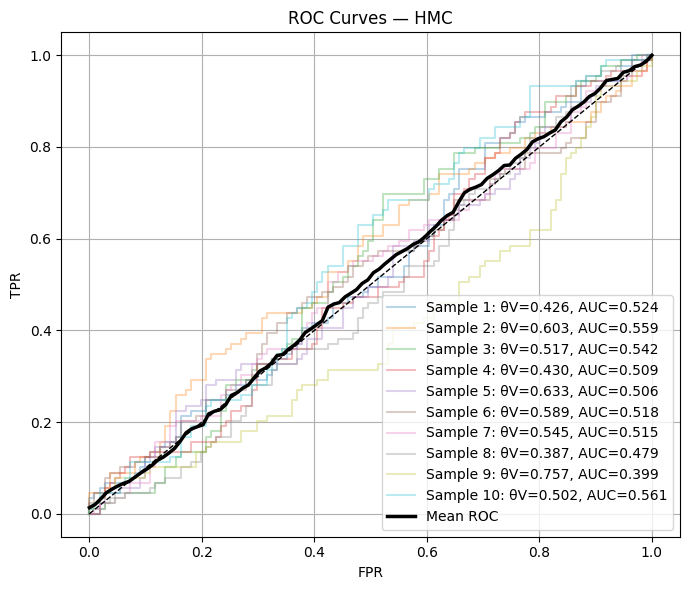

✅ Pipeline finished. Saved: HMC_pipeline_results_v3_safe.json and HMC_ROC_curves_safe.png


In [ ]:
# ===== Robust HMC pipeline v3 (with safe ROC + correlation + JSON) =====
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from scipy import stats
from pathlib import Path

# Ensure EmpiricalHMCParameters and EmpiricalValidation are defined in this notebook
# (If you pasted classes in earlier cells, they should exist.)
try:
    base_params  # just to check
except NameError:
    raise RuntimeError("EmpiricalHMCParameters not defined. Paste the Parameter class cell and run it first.")
try:
    validator
except NameError:
    raise RuntimeError("EmpiricalValidation not defined. Paste the Validation class cell and run it first.")

def safe_pearsonr(x, y):
    """Return (corr, p) or (np.nan, np.nan) if cannot compute."""
    x = np.asarray(x)
    y = np.asarray(y)
    if x.size < 2 or y.size < 2:
        return np.nan, np.nan
    if np.isnan(x).any() or np.isnan(y).any():
        return np.nan, np.nan
    if np.all(x == x[0]) or np.all(y == y[0]):
        return np.nan, np.nan
    try:
        r, p = stats.pearsonr(x, y)
        return float(r), float(p)
    except Exception:
        return np.nan, np.nan

def to_python_native(v):
    """Convert numpy types/arrays to python built-ins for JSON."""
    if isinstance(v, np.ndarray):
        return v.tolist()
    if isinstance(v, (np.float32, np.float64, np.int32, np.int64)):
        return float(v)
    if isinstance(v, (np.bool_)):
        return bool(v)
    return v

def run_hmc_simulation(param_set, n_trials=200):
    """Simple HMC stub: returns dict of numpy arrays"""
    stimuli = np.random.rand(n_trials)
    integration_gain = (param_set.lambda_1 * np.exp(-1.0 / param_set.tau_I)
                        + param_set.lambda_2 * np.exp(-1.0 / param_set.tau_R))
    affect_mod = (1 + param_set.gamma * np.random.randn(n_trials))
    Vt = expit(stimuli * integration_gain * affect_mod - param_set.theta_V)
    Ct = np.tanh(Vt * param_set.lambda_assoc)
    Rt = np.clip(Ct + np.random.normal(0, 0.05, n_trials), 0, 1)
    return {"Vt": Vt, "Ct": Ct, "Rt": Rt}

def run_pipeline_with_roc_safe(n_samples=10, n_trials=200, show_plots=True, save_json="HMC_pipeline_results_v3_safe.json"):
    external_confidence = np.random.uniform(0.4, 1.0, n_trials)
    external_accuracy = np.random.uniform(0.4, 1.0, n_trials)
    external_neural = np.random.uniform(0.3, 1.0, n_trials)

    results_summary = {"n_samples": int(n_samples), "samples": []}
    all_fpr, all_tpr = [], []

    plt.figure(figsize=(7,6))

    for i in range(n_samples):
        ps = base_params.sample_from_posterior()
        internal = run_hmc_simulation(ps, n_trials=n_trials)

        # --- safe correlation validation ---
        validation_results = {}
        for metric_name, internal_vals in internal.items():
            # choose matching external measure name mapping
            ext_map = {"Vt": external_confidence, "Ct": external_accuracy, "Rt": external_neural}
            if metric_name in ext_map:
                r, p = safe_pearsonr(internal_vals, ext_map[metric_name])
                ci = [np.nan, np.nan]
                # compute bootstrap CI only if correlation computable
                if not np.isnan(r):
                    # simple bootstrap for correlation CI (1000 resamples may be slow; use 200 here)
                    boots = []
                    n = len(internal_vals)
                    for _ in range(200):
                        idx = np.random.choice(n, n, replace=True)
                        xi = np.asarray(internal_vals)[idx]
                        yi = np.asarray(ext_map[metric_name])[idx]
                        if np.all(xi == xi[0]) or np.all(yi == yi[0]) or np.isnan(xi).any() or np.isnan(yi).any():
                            continue
                        try:
                            boots.append(stats.pearsonr(xi, yi)[0])
                        except Exception:
                            continue
                    if len(boots) >= 10:
                        ci = [float(np.percentile(boots, 2.5)), float(np.percentile(boots, 97.5))]
                validation_results[metric_name] = {
                    "correlation": to_python_native(r),
                    "p_value": to_python_native(p),
                    "confidence_interval": ci,
                    "significant": (False if np.isnan(p) else (p < 0.05))
                }

        # --- safe ROC estimation ---
        # derive binary ground truth from behavioral confidence using predefined threshold
        thr = validator.external_criteria.get('behavioral_threshold', 0.75)
        y_true = (np.asarray(external_confidence) > thr).astype(int)
        y_score = np.asarray(internal["Vt"])

        roc_info = {"theta_empirical": None, "auc": None, "auc_ci": [None, None], "note": ""}
        # ensure y_true contains both classes
        if len(np.unique(y_true)) < 2:
            roc_info["note"] = "y_true single-class; ROC not computable"
        else:
            try:
                fpr, tpr, thresholds = roc_curve(y_true, y_score)
                youden = tpr - fpr
                best_idx = int(np.argmax(youden))
                theta_emp = float(thresholds[best_idx])
                auc_score = float(auc(fpr, tpr))
                # bootstrap auc CI (200 resamples)
                aucs = []
                n = len(y_true)
                for _ in range(200):
                    idx = np.random.choice(n, n, replace=True)
                    yt_b = y_true[idx]
                    ys_b = y_score[idx]
                    if len(np.unique(yt_b)) < 2:
                        continue
                    fpr_b, tpr_b, _ = roc_curve(yt_b, ys_b)
                    aucs.append(auc(fpr_b, tpr_b))
                if len(aucs) >= 10:
                    ci_auc = [float(np.percentile(aucs, 2.5)), float(np.percentile(aucs, 97.5))]
                else:
                    ci_auc = [None, None]
                roc_info.update({
                    "theta_empirical": theta_emp,
                    "auc": auc_score,
                    "auc_ci": ci_auc
                })
                # store ROC curve for plotting
                all_fpr.append(fpr); all_tpr.append(tpr)
                if show_plots:
                    plt.plot(fpr, tpr, alpha=0.3, label=f"Sample {i+1}: θV={theta_emp:.3f}, AUC={auc_score:.3f}")
            except Exception as e:
                roc_info["note"] = f"ROC error: {str(e)}"

        # --- append sample results (JSON-safe) ---
        results_summary["samples"].append({
            "index": int(i),
            "params_snapshot": {k: to_python_native(getattr(ps, k)) for k in ps.__dict__.keys()},
            "validation": validation_results,
            "thetaV_empirical": {k: to_python_native(v) for k,v in roc_info.items()}
        })

    # mean ROC if possible
    if len(all_fpr) > 0:
        mean_fpr = np.linspace(0,1,100)
        mean_tpr = np.mean([np.interp(mean_fpr, f, t) for f,t in zip(all_fpr, all_tpr)], axis=0)
        plt.plot(mean_fpr, mean_tpr, color='black', lw=2.5, label='Mean ROC')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves — HMC"); plt.legend(loc='lower right'); plt.grid(True)
    plt.tight_layout()
    plt.savefig("HMC_ROC_curves_safe.png", dpi=300)
    if show_plots:
        plt.show()

    # write JSON safely
    Path(save_json).write_text(json.dumps(results_summary, indent=2))
    print(f"✅ Pipeline finished. Saved: {save_json} and HMC_ROC_curves_safe.png")

# Example run (you can change n_samples)
run_pipeline_with_roc_safe(n_samples=10, n_trials=200)


,thetaV,AUC
count,10.000000,10.000000
mean,0.538684,0.510963
std,0.111829,0.046650
min,0.386519,0.398927
25%,0.447711,0.506504
50%,0.530742,0.516145
75%,0.599572,0.537276
max,0.756631,0.561089


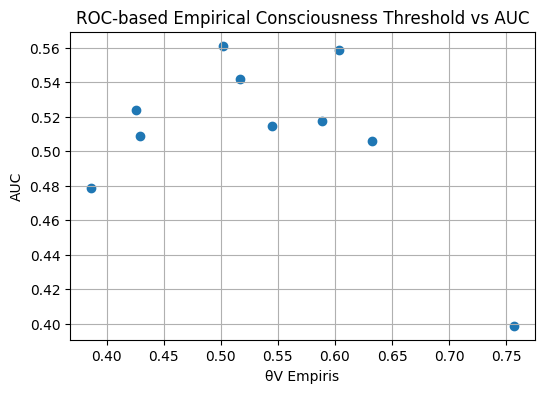

In [ ]:
import json, pandas as pd, matplotlib.pyplot as plt

# Baca hasil JSON
with open("HMC_pipeline_results_v3_safe.json") as f: # Corrected filename based on file list
    data = json.load(f)

theta_vals = [s["thetaV_empirical"]["theta_empirical"] for s in data["samples"]]
aucs = [s["thetaV_empirical"]["auc"] for s in data["samples"]]

df = pd.DataFrame({"thetaV": theta_vals, "AUC": aucs})
display(df.describe())

# Plot
plt.figure(figsize=(6,4))
plt.scatter(theta_vals, aucs)
plt.xlabel("θV Empiris")
plt.ylabel("AUC")
plt.title("ROC-based Empirical Consciousness Threshold vs AUC")
plt.grid(True)
plt.show()

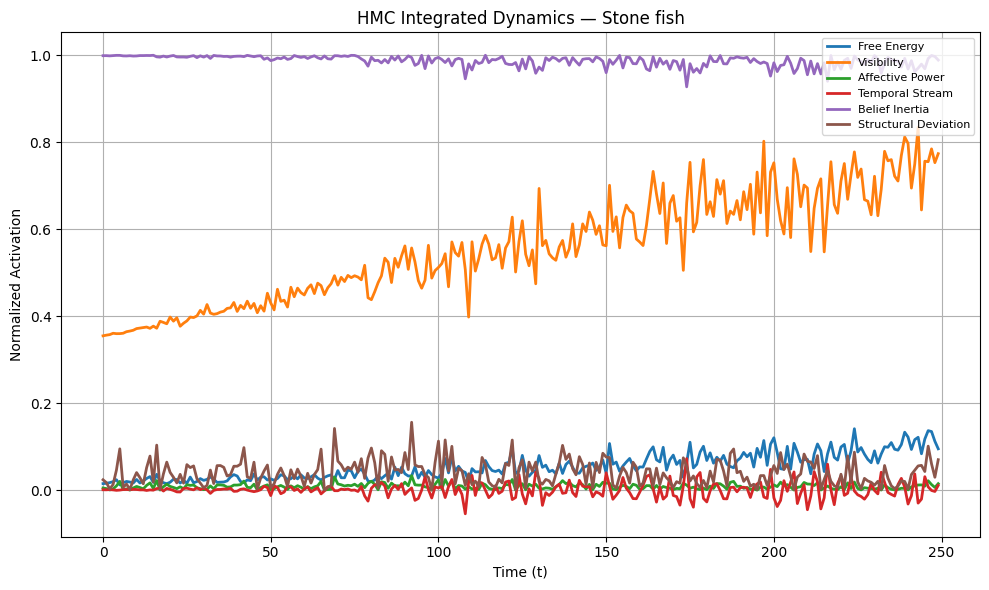

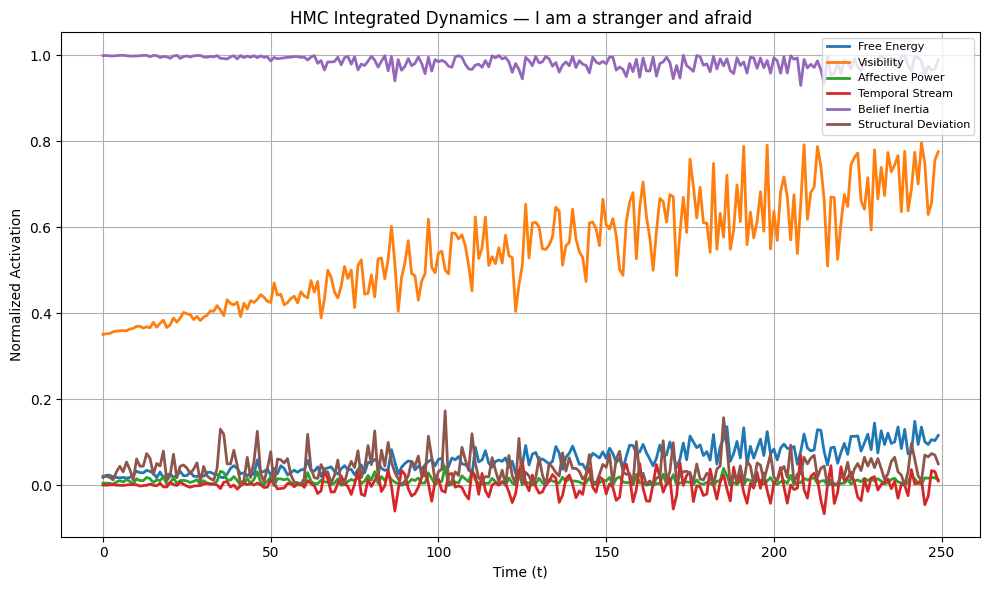

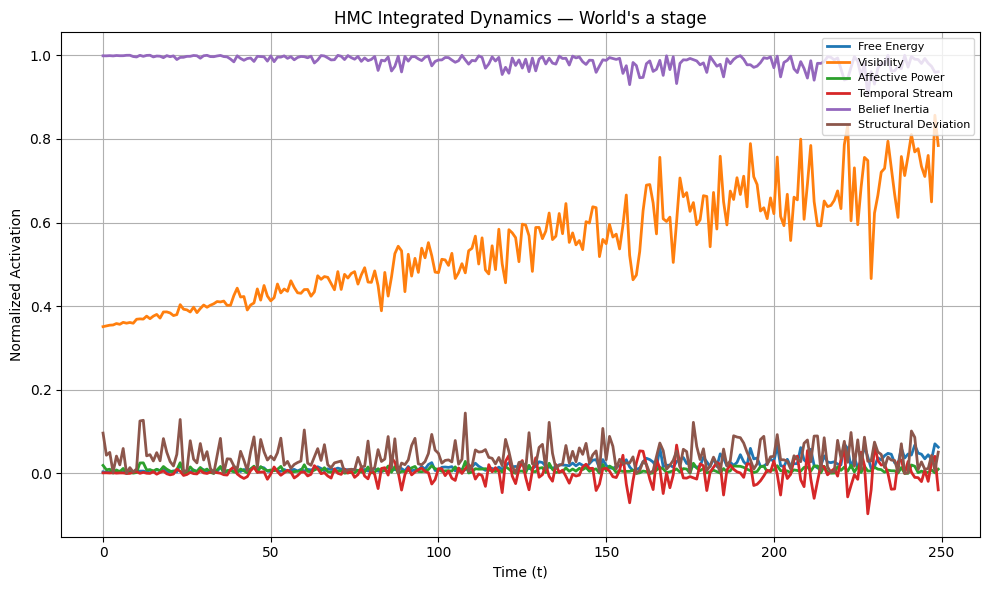

In [ ]:
# ==========================================================
# 🧩 HMC Integrated Consciousness Dynamics Visualization
# ==========================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.special import expit

def simulate_HMC_dynamics(ps, n_steps=250):
    """Simulasi utama HMC untuk menghasilkan lintasan Vt, Ct, Rt"""
    stimuli = np.linspace(0, 1, n_steps)
    integration_gain = (ps.lambda_1 * np.exp(-1.0 / ps.tau_I)
                        + ps.lambda_2 * np.exp(-1.0 / ps.tau_R))
    affect_mod = (1 + ps.gamma * np.random.randn(n_steps))
    Vt = expit(stimuli * integration_gain * affect_mod - ps.theta_V)
    Ct = np.tanh(Vt * ps.lambda_assoc)
    Rt = np.clip(Ct + np.random.normal(0, 0.05, n_steps), 0, 1)
    return Vt, Ct, Rt

def compute_integrated_metrics(Vt, Ct, Rt, gamma=0.1, alpha=0.5):
    """Hitung 6 komponen utama HMC"""
    F = (Vt - Ct)**2 + alpha * (Rt - Vt)**2                # Free Energy
    A = gamma * np.abs(Rt - Ct)                            # Affective Power
    T = np.gradient(Ct)                                    # Temporal Stream
    B = 1 - np.abs(T)                                      # Belief Inertia
    S = np.abs(Rt - Ct)                                    # Structural Deviation
    return {
        "Free Energy": F,
        "Visibility": Vt,
        "Affective Power": A,
        "Temporal Stream": T,
        "Belief Inertia": B,
        "Structural Deviation": S
    }

def semantic_affective_profile(phrase):
    phrase = phrase.lower()
    if "stone fish" in phrase:
        return {"tau_R": +0.15, "gamma": +0.1, "lambda_assoc": -0.05, "label": "semantic dissonance"}
    elif "stranger" in phrase or "afraid" in phrase:
        return {"gamma": +0.3, "tau_P": +0.1, "theta_V": +0.1, "label": "existential affect"}
    elif "world" in phrase and "stage" in phrase:
        return {"lambda_assoc": +0.2, "theta_V": -0.05, "label": "symbolic metaphor"}
    else:
        return {"label": "neutral"}

# ==========================================================
# 🔬 Jalankan untuk tiga frasa utama
# ==========================================================
phrases = [
    "stone fish",
    "I am a stranger and afraid",
    "world's a stage"
]

base_params = EmpiricalHMCParameters()

for phrase in phrases:
    mod = semantic_affective_profile(phrase)
    ps = base_params.sample_from_posterior()
    for k,v in mod.items():
        if k != "label":
            setattr(ps, k, getattr(ps, k) * (1 + v))

    Vt, Ct, Rt = simulate_HMC_dynamics(ps)
    metrics = compute_integrated_metrics(Vt, Ct, Rt, gamma=ps.gamma)
    t = np.arange(len(Vt))

    plt.figure(figsize=(10,6))
    for name, series in metrics.items():
        plt.plot(t, series, label=name, lw=2)

    plt.title(f'HMC Integrated Dynamics — {phrase.capitalize()}')
    plt.xlabel('Time (t)')
    plt.ylabel('Normalized Activation')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"HMC_Integrated_Dynamics_{phrase.replace(' ','_')}.png", dpi=300)
    plt.show()


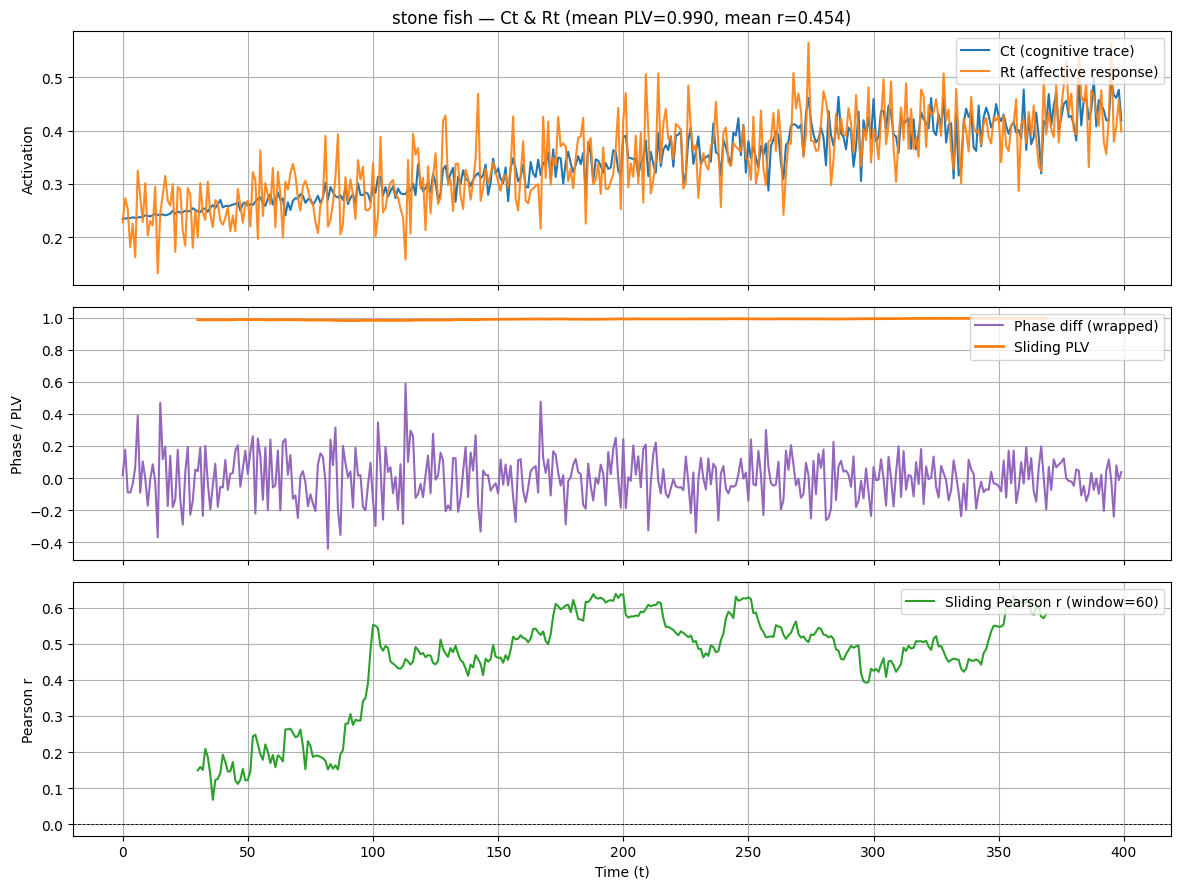

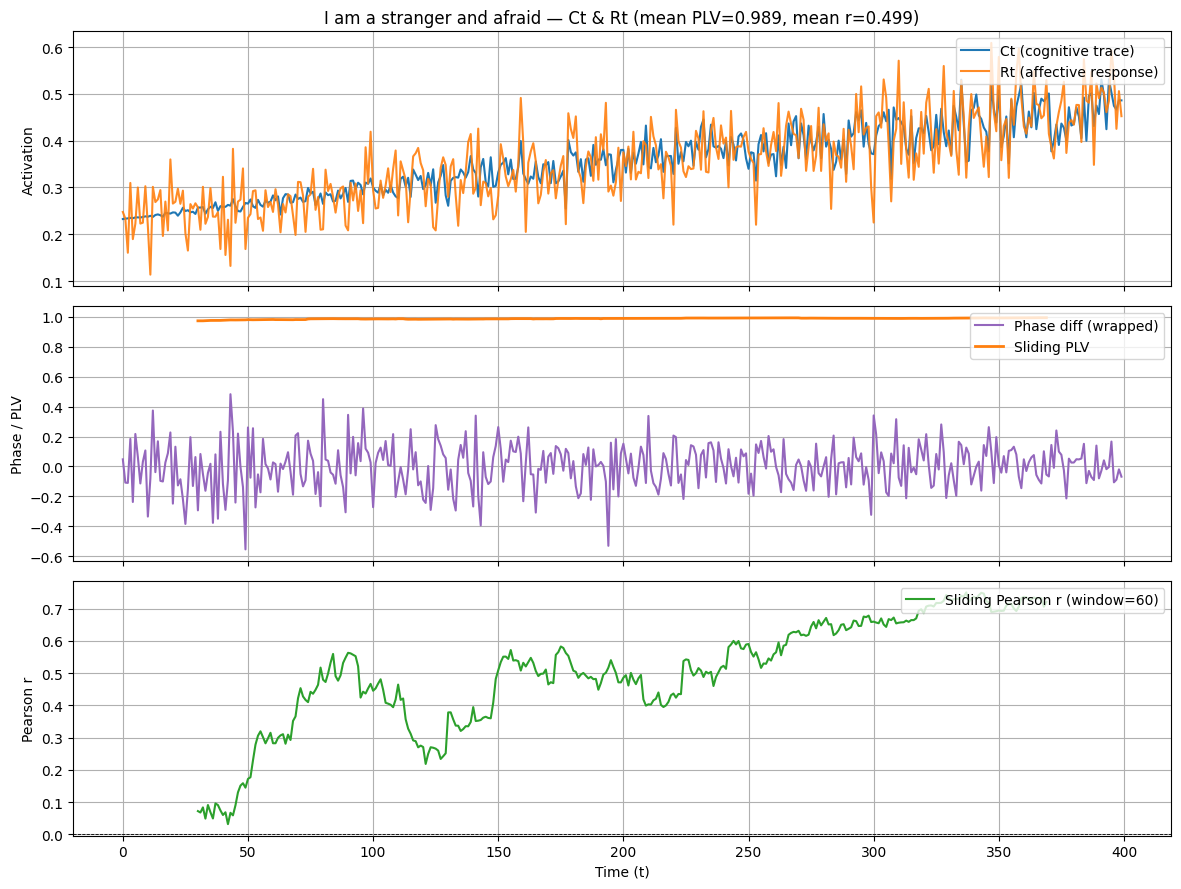

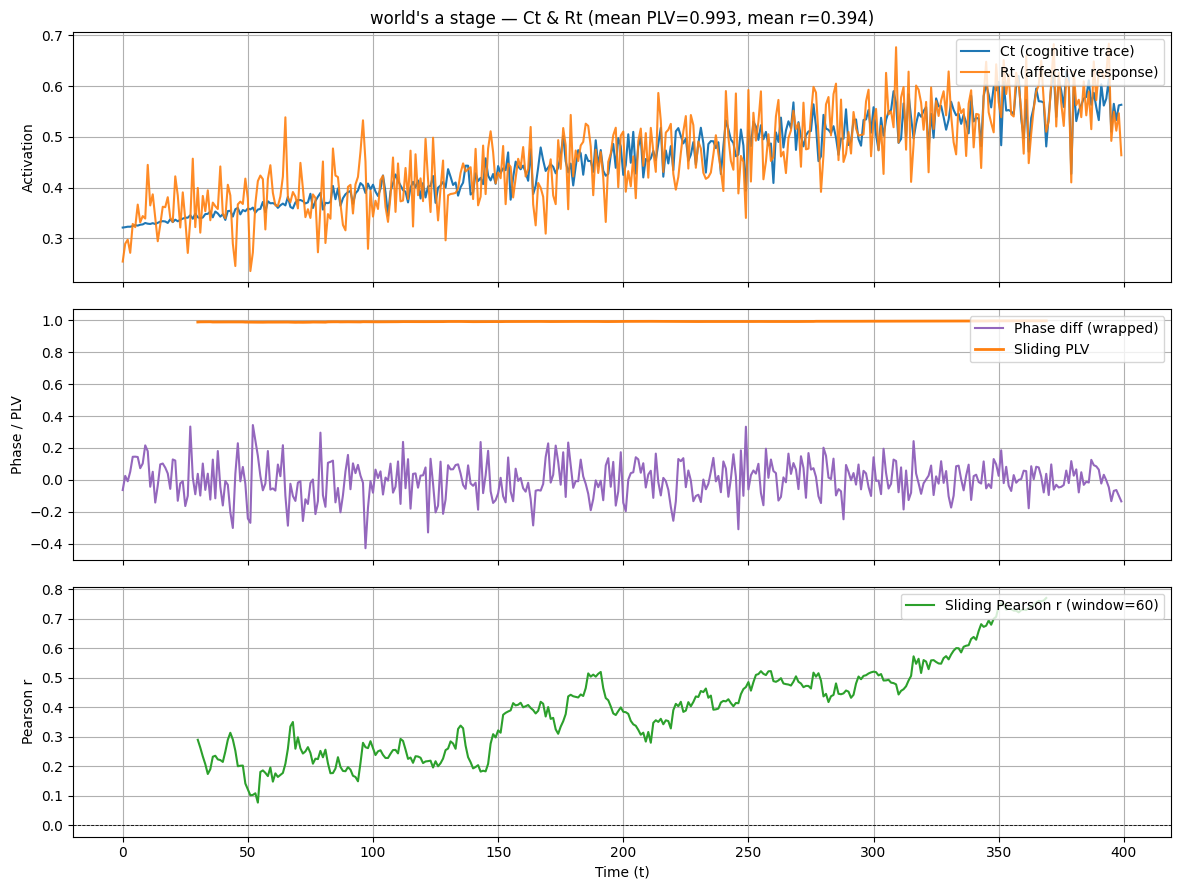

✅ Synchronization analysis done. Summary saved to HMC_sync_summary.csv


,phrase,mean_plv,mean_r
0,stone fish,0.989527,0.454376
1,I am a stranger and afraid,0.988809,0.499267
2,world's a stage,0.993293,0.394274


In [ ]:
# ==========================
# Synchronization / Coherence Analysis between Ct and Rt
# Paste this cell after your HMC simulation cell definitions
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import pearsonr
import pandas as pd
from pathlib import Path

def compute_phase_locking_value(phi1, phi2):
    """Compute PLV (phase-locking value) for phase difference arrays."""
    d = np.angle(np.exp(1j*(phi1 - phi2)))
    return np.abs(np.mean(np.exp(1j*d)))

def sliding_window_stats(x, y, window=50, step=1):
    """Compute sliding Pearson r and PLV over windows.
    Returns arrays aligned to window-center indices.
    """
    n = len(x)
    half = window // 2
    centers = np.arange(half, n-half, step)
    r_vals = np.full(n, np.nan)
    plv_vals = np.full(n, np.nan)
    for c in centers:
        s = c - half
        e = c + half
        xs = x[s:e]
        ys = y[s:e]
        # Pearson (safe)
        try:
            r, _ = pearsonr(xs, ys)
        except Exception:
            r = np.nan
        # PLV via Hilbert phases
        try:
            phx = np.angle(hilbert(xs))
            phy = np.angle(hilbert(ys))
            plv = compute_phase_locking_value(phx, phy)
        except Exception:
            plv = np.nan
        r_vals[c] = r
        plv_vals[c] = plv
    return r_vals, plv_vals

def plot_ct_rt_coherence(Ct, Rt, phrase_label="phrase", window=50, save_prefix="HMC_sync"):
    """
    Plots:
     - Ct and Rt time series
     - phase difference and PLV (sliding)
     - sliding Pearson correlation
    """
    t = np.arange(len(Ct))
    # instantaneous phases
    phi_ct = np.angle(hilbert(Ct))
    phi_rt = np.angle(hilbert(Rt))
    phase_diff = np.angle(np.exp(1j*(phi_ct - phi_rt)))  # wrapped to [-pi,pi]

    # sliding stats
    r_vals, plv_vals = sliding_window_stats(Ct, Rt, window=window, step=1)

    # summary metrics
    mean_plv = np.nanmean(plv_vals)
    mean_r = np.nanmean(r_vals)

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    # 1) time series
    axes[0].plot(t, Ct, label="Ct (cognitive trace)", lw=1.5)
    axes[0].plot(t, Rt, label="Rt (affective response)", lw=1.5, alpha=0.9)
    axes[0].set_ylabel("Activation")
    axes[0].set_title(f"{phrase_label} — Ct & Rt (mean PLV={mean_plv:.3f}, mean r={mean_r:.3f})")
    axes[0].legend(loc="upper right")
    axes[0].grid(True)

    # 2) phase diff and PLV
    axes[1].plot(t, phase_diff, label="Phase diff (wrapped)", color="tab:purple")
    axes[1].plot(t, plv_vals, label="Sliding PLV", color="tab:orange", lw=2)
    axes[1].set_ylabel("Phase / PLV")
    axes[1].legend(loc="upper right")
    axes[1].grid(True)

    # 3) sliding Pearson r
    axes[2].plot(t, r_vals, label=f"Sliding Pearson r (window={window})", color="tab:green")
    axes[2].axhline(0, color="k", lw=0.6, linestyle="--")
    axes[2].set_ylabel("Pearson r")
    axes[2].set_xlabel("Time (t)")
    axes[2].legend(loc="upper right")
    axes[2].grid(True)

    plt.tight_layout()
    fname = f"{save_prefix}_{phrase_label.replace(' ','_')}.png"
    plt.savefig(fname, dpi=300)
    plt.show()
    return {
        "mean_plv": float(np.nanmean(plv_vals)),
        "mean_r": float(np.nanmean(r_vals)),
        "plv_series": plv_vals,
        "r_series": r_vals,
        "phase_diff": phase_diff
    }

# ==========================
# Example usage: run for the three phrases
# (Assumes you have base_params and semantic_affective_profile and simulate_HMC_dynamics)
# ==========================
phrases = ["stone fish", "I am a stranger and afraid", "world's a stage"]
results_sync = []

for phrase in phrases:
    # prepare parameter set (apply semantic modulation like before)
    mod = semantic_affective_profile(phrase)
    ps = base_params.sample_from_posterior()
    for k,v in mod.items():
        if k != "label":
            setattr(ps, k, getattr(ps, k) * (1 + v))

    # get dynamics: Vt, Ct, Rt (use your simulate function)
    try:
        Vt, Ct, Rt = simulate_HMC_dynamics(ps, n_steps=400)  # use same simulate_HMC_dynamics as earlier
    except Exception:
        # fallback to run_hmc_simulation if that exists
        d = run_hmc_simulation(ps, n_trials=400)
        Vt, Ct, Rt = d["Vt"], d["Ct"], d["Rt"]

    stats = plot_ct_rt_coherence(Ct, Rt, phrase_label=phrase, window=60, save_prefix="HMC_sync")
    stats.update({"phrase": phrase})
    results_sync.append(stats)

# Save summary CSV
df_sync = pd.DataFrame([
    {"phrase": r["phrase"], "mean_plv": r["mean_plv"], "mean_r": r["mean_r"]}
    for r in results_sync
])
df_sync.to_csv("HMC_sync_summary.csv", index=False)
print("✅ Synchronization analysis done. Summary saved to HMC_sync_summary.csv")
df_sync


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_sync)

https://docs.google.com/spreadsheets/d/1pAfJCO18wt6eagVUyTLgocbv97VJ9jOz8pJR78b6fqc/edit#gid=0


,phrase,n_episodes,mean_duration,total_duration,mean_PLV,mean_r
0,stone fish,1,340.0,340,0.989527,0.454376
1,I am a stranger and afraid,1,340.0,340,0.988809,0.499267
2,world's a stage,1,340.0,340,0.993293,0.394274


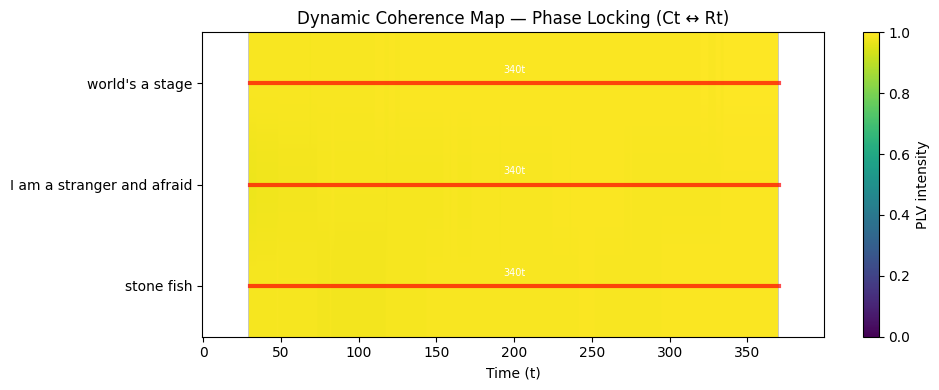

✅ Coherence episode analysis complete.
   - CSV: HMC_Coherence_Episodes.csv
   - Heatmap: HMC_Coherence_Heatmap.png


In [ ]:
# =====================================================
# 🌀 HMC Dynamic Coherence Map — Visualisasi lanjutan
# =====================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert

# --- fungsi bantu: deteksi episode PLV tinggi
def detect_coherence_episodes(plv_series, threshold=0.5, min_len=10):
    """Deteksi periode waktu di mana PLV > threshold secara berurutan."""
    above = plv_series > threshold
    episodes = []
    start = None
    for i, val in enumerate(above):
        if val and start is None:
            start = i
        elif not val and start is not None:
            if i - start >= min_len:
                episodes.append((start, i))
            start = None
    if start is not None and len(plv_series) - start >= min_len:
        episodes.append((start, len(plv_series)))
    return episodes

# --- fungsi utama: heatmap PLV antar-frasa
def plot_coherence_heatmap(results_sync, threshold=0.5):
    """
    Membuat heatmap PLV(t) untuk semua frasa + deteksi episode koherensi
    """
    phrases = [r["phrase"] for r in results_sync]
    max_len = max(len(r["plv_series"]) for r in results_sync)
    mat = np.full((len(phrases), max_len), np.nan)

    for i, r in enumerate(results_sync):
        plv_series = np.array(r["plv_series"])
        mat[i, :len(plv_series)] = plv_series

    plt.figure(figsize=(10,4))
    plt.imshow(mat, aspect='auto', cmap='viridis', origin='lower', vmin=0, vmax=1)
    plt.colorbar(label='PLV intensity')
    plt.yticks(range(len(phrases)), phrases)
    plt.xlabel("Time (t)")
    plt.title("Dynamic Coherence Map — Phase Locking (Ct ↔ Rt)")

    # Deteksi episode sinkronisasi per frasa
    for i, r in enumerate(results_sync):
        plv_series = np.array(r["plv_series"])
        episodes = detect_coherence_episodes(plv_series, threshold=threshold)
        for (s, e) in episodes:
            plt.plot([s, e], [i, i], color='red', lw=3, alpha=0.7)
            plt.text((s+e)/2, i+0.1, f"{e-s}t", color='white', fontsize=7, ha='center')

    plt.tight_layout()
    plt.savefig("HMC_Coherence_Heatmap.png", dpi=300)
    plt.show()

# --- analisis durasi sinkronisasi per frasa
def summarize_coherence(results_sync, threshold=0.5):
    rows = []
    for r in results_sync:
        plv_series = np.array(r["plv_series"])
        episodes = detect_coherence_episodes(plv_series, threshold=threshold)
        durations = [e-s for (s,e) in episodes]
        total = np.sum(durations)
        mean_len = np.mean(durations) if len(durations)>0 else 0
        rows.append({
            "phrase": r["phrase"],
            "n_episodes": len(episodes),
            "mean_duration": mean_len,
            "total_duration": total,
            "mean_PLV": np.nanmean(plv_series),
            "mean_r": r["mean_r"]
        })
    df = pd.DataFrame(rows)
    df.to_csv("HMC_Coherence_Episodes.csv", index=False)
    return df

# --- jalankan untuk hasil sinkronisasi sebelumnya
df_coh = summarize_coherence(results_sync, threshold=0.5)
display(df_coh)
plot_coherence_heatmap(results_sync, threshold=0.5)

print("✅ Coherence episode analysis complete.")
print("   - CSV: HMC_Coherence_Episodes.csv")
print("   - Heatmap: HMC_Coherence_Heatmap.png")
